# 06 Modelling (Feature Extraction)

In this notebbook, we examine the effect of feature extraction.

In [22]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

from xgboost import XGBRegressor
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import shap
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt


In [23]:
df_train = pd.read_csv("data/df_train_app.csv", index_col=0).dropna(subset="population")
df_test = pd.read_csv("data/df_test_app.csv", index_col=0).dropna(subset="population")
df_val = pd.read_csv("data/df_val_app.csv", index_col=0).dropna(subset="population")

In [24]:
# some loss functions
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true) ** 2))

def smape(y_true, y_pred):
    return np.mean(200 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def rmspe(y_true, y_pred):
    epsilon = 1e-6  # Small constant to avoid division by zero
    return np.sqrt(np.mean(((y_true - y_pred) / (y_true + epsilon)) ** 2))

In [25]:
df_train_2 = df_train.dropna(subset="population")
df_test_2 = df_test.dropna(subset="population")
df_val_2 = df_val.dropna(subset="population")

In [26]:
X_train_prior = df_train_2.drop(columns=["appreciation", "price", "id", "prior_saledate", "prior_price"])
X_val_prior = df_val_2.drop(columns=["appreciation","price", "id", "prior_saledate", "prior_price"])
X_test_prior = df_test_2.drop(columns=["appreciation","price", "id", "prior_saledate", "prior_price"])

y_train = df_train_2.loc[:, "price"]
y_val = df_val_2.loc[:, "price"]
y_test = df_test_2.loc[:, "price"]

In [27]:
y_train_prior = df_train_2.loc[:, "prior_price"]
y_val_prior = df_val_2.loc[:, "prior_price"]
y_test_prior = df_test_2.loc[:, "prior_price"]

In [28]:
columns = ['city', 'yrblt', 'effyrblt', 'nbed', 'nbath', 'nhalfbath', 'livarea',
       'efflivarea', 'distance_aerodrome', 'distance_ferry_terminal',
       'distance_railway_station', 'distance_market', 'distance_hospital',
       'distance_hotel', 'distance_museum', 'n_reli_inst', 'n_edu_fac',
       'n_healthcare', 'n_emergency', 'n_animalcare', 'n_commu_venu',
       'n_commu_serv', 'n_food_drink', 'n_financial', 'n_transport',
       'n_entertainment', 'n_sports', 'n_utilities', 'n_accommodation',
       'n_government_civic', 'n_recreational', 'year', 'hpi',
       'household_income', 'new_housing', 'population', 'n_poverty',
       'n_poverty_young', 'unemployment_rate', 'n_employed', 'age', 'eff_age',
       'longitude', 'latitude', 'county_Fairfield', 'county_Litchfield',
       'cond_desc_Average', 'cond_desc_Fair', 'cond_desc_Good',
       'cond_desc_Poor']

In [29]:
X_train_prior = X_train_prior[columns]
X_test_prior = X_test_prior[columns]
X_val_prior = X_val_prior[columns]

In [30]:
pca = PCA(n_components=3)

In [31]:
X_train_prior_2 = pd.concat([X_train_prior, pd.DataFrame(pca.fit_transform(X_train_prior), index=X_train_prior.index)], axis=1)
X_val_prior_2 = pd.concat([X_val_prior, pd.DataFrame(pca.fit_transform(X_val_prior), index=X_val_prior.index)], axis=1)
X_test_prior_2 = pd.concat([X_test_prior, pd.DataFrame(pca.fit_transform(X_test_prior), index=X_test_prior.index)], axis=1)

In [32]:
columns = ['longitude', 'latitude', 'county_Fairfax', 'county_Fairfield',
       'county_Hartford', 'county_Litchfield', 'county_Middlesex',
       'county_New Haven', 'county_New London', 'county_Tolland',
       'county_Windham', 'state_Connecticut', 'state_Virginia',
       'cond_desc_Average', 'cond_desc_Average Plus', 'cond_desc_Fair',
       'cond_desc_Good', 'cond_desc_Poor']
columns = list(set(X_train_prior_2.columns) & set(columns))
X_train_prior_2 = X_train_prior_2.rename(columns={0:"pca_0", 1:"pca_1", 2:"pca_2"})
X_test_prior_2 = X_test_prior_2.rename(columns={0:"pca_0", 1:"pca_1", 2:"pca_2"})
X_val_prior_2 = X_val_prior_2.rename(columns={0:"pca_0", 1:"pca_1", 2:"pca_2"})


scaler = StandardScaler()

X_train_scaled = X_train_prior_2.drop(columns=columns)
X_test_scaled = X_test_prior_2.drop(columns=columns)
X_val_scaled = X_val_prior_2.drop(columns=columns)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_scaled), columns=X_train_scaled.columns, index=X_train_scaled.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_scaled), columns=X_test_scaled.columns, index=X_test_scaled.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val_scaled), columns=X_val_scaled.columns, index=X_val_scaled.index)
X_train_scaled = pd.concat([X_train_prior.loc[:, columns], X_train_scaled], axis=1)
X_test_scaled = pd.concat([X_test_prior.loc[:, columns], X_test_scaled], axis=1)
X_val_scaled = pd.concat([X_val_prior.loc[:, columns], X_val_scaled], axis=1)

In [33]:
k = 6 # You can choose the number of clusters based on your analysis
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_train_scaled)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=6, random_state=42)

In [34]:
X_train_prior_2 = pd.concat([X_train_prior_2, pd.DataFrame(kmeans.transform(X_train_scaled), index=X_train_prior_2.index)], axis=1)
X_test_prior_2 = pd.concat([X_test_prior_2, pd.DataFrame(kmeans.transform(X_test_scaled), index=X_test_prior_2.index)], axis=1)
X_val_prior_2= pd.concat([X_val_prior_2, pd.DataFrame(kmeans.transform(X_val_scaled), index=X_val_prior_2.index)], axis=1)

In [35]:
# predict prior price
parameters = {"objective": 'reg:squarederror',
            "n_estimators":350,  # Number of boosting rounds
            "learning_rate":0.1,  # Step size shrinkage
            "max_depth":10,  # Maximum depth of a tree
            }

    
model_prior = XGBRegressor(**parameters)
model_prior.fit(X_train_prior_2, y_train_prior)
y_hat_prior = model_prior.predict(X_val_prior_2)

print(f"MSE: {mean_squared_error(y_true=y_val_prior, y_pred=y_hat_prior)}")
print(f"MAE: {mean_absolute_error(y_true=y_val_prior, y_pred=y_hat_prior)}")
print(f"MAPE: {mean_absolute_percentage_error(y_true=y_val_prior, y_pred=y_hat_prior)}")
print(f"R2: {r2_score(y_true=y_val_prior, y_pred=y_hat_prior)}")
print(f"RMSE: {rmse(y_true=y_val_prior, y_pred=y_hat_prior)}")
print(f"SMAPE: {smape(y_true=y_val_prior, y_pred=y_hat_prior)}")
print(f"RMSPE: {rmspe(y_true=y_val_prior, y_pred=y_hat_prior)}")

MSE: 21857016793.08298
MAE: 59325.246938719196
MAPE: 0.31774004512544185
R2: 0.8246679351354798
RMSE: 147841.18774239803
SMAPE: 18.22856502266729
RMSPE: 2.6964687697536567


In [36]:
X_train_appr_2 = X_train_prior_2.copy()
X_test_appr_2 = X_test_prior_2.copy()
X_val_appr_2 = X_val_prior_2.copy()

In [37]:
y_hat_train = model_prior.predict(X_train_prior_2)
y_hat_val = model_prior.predict(X_val_prior_2)
y_hat_test = model_prior.predict(X_test_prior_2)

In [38]:
X_train_appr_2["pred_prior_price"] = y_hat_train
X_val_appr_2["pred_prior_price"] = y_hat_val
X_test_appr_2["pred_prior_price"] = y_hat_test

In [39]:
# predict future price
parameters = {"objective": 'reg:squarederror',
            "n_estimators":350,  # Number of boosting rounds
            "learning_rate":0.1,  # Step size shrinkage
            "max_depth":10,  # Maximum depth of a tree
            }

    
model = XGBRegressor(**parameters)
model.fit(X_train_appr_2, y_train)
y_hat = model.predict(X_val_appr_2)

print(f"MSE: {mean_squared_error(y_true=y_val, y_pred=y_hat)}")
print(f"MAE: {mean_absolute_error(y_true=y_val, y_pred=y_hat)}")
print(f"MAPE: {mean_absolute_percentage_error(y_true=y_val, y_pred=y_hat)}")
print(f"R2: {r2_score(y_true=y_val, y_pred=y_hat)}")
print(f"RMSE: {rmse(y_true=y_val, y_pred=y_hat)}")
print(f"SMAPE: {smape(y_true=y_val, y_pred=y_hat)}")
print(f"RMSPE: {rmspe(y_true=y_val, y_pred=y_hat)}")

MSE: 28792039967.039116
MAE: 64902.86904116897
MAPE: 0.1748440905881417
R2: 0.8527112963280965
RMSE: 169682.17339201874
SMAPE: 13.36324707048929
RMSPE: 0.8621946952804941


In [40]:
y_hat_appr = (y_hat - y_hat_prior)/y_hat_prior
y_appr = (y_val - y_hat_prior)/y_hat_prior

In [41]:
print(f"MSE: {mean_squared_error(y_true=y_appr, y_pred=y_hat_appr)}")
print(f"MAE: {mean_absolute_error(y_true=y_appr, y_pred=y_hat_appr)}")
print(f"MAPE: {mean_absolute_percentage_error(y_true=y_appr, y_pred=y_hat_appr)}")
print(f"R2: {r2_score(y_true=y_appr, y_pred=y_hat_appr)}")
print(f"RMSE: {rmse(y_true=y_appr, y_pred=y_hat_appr)}")
print(f"SMAPE: {smape(y_true=y_appr, y_pred=y_hat_appr)}")
print(f"RMSPE: {rmspe(y_true=y_appr, y_pred=y_hat_appr)}")

MSE: 0.9145181962115421
MAE: 0.21318037303100779
MAPE: 2.7336057415587125
R2: 0.9192788042782525
RMSE: 0.9563044474494208
SMAPE: 58.119775161460424
RMSPE: 89.26524684705142


In [42]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val_appr_2)

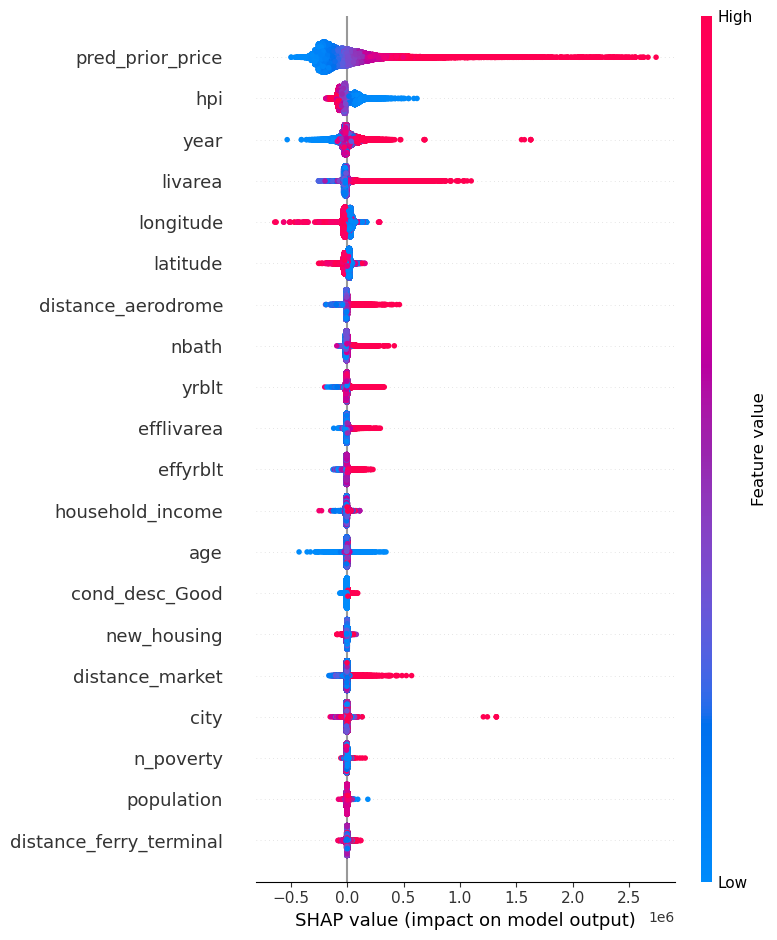

In [43]:
shap.summary_plot(shap_values, X_val_appr_2)

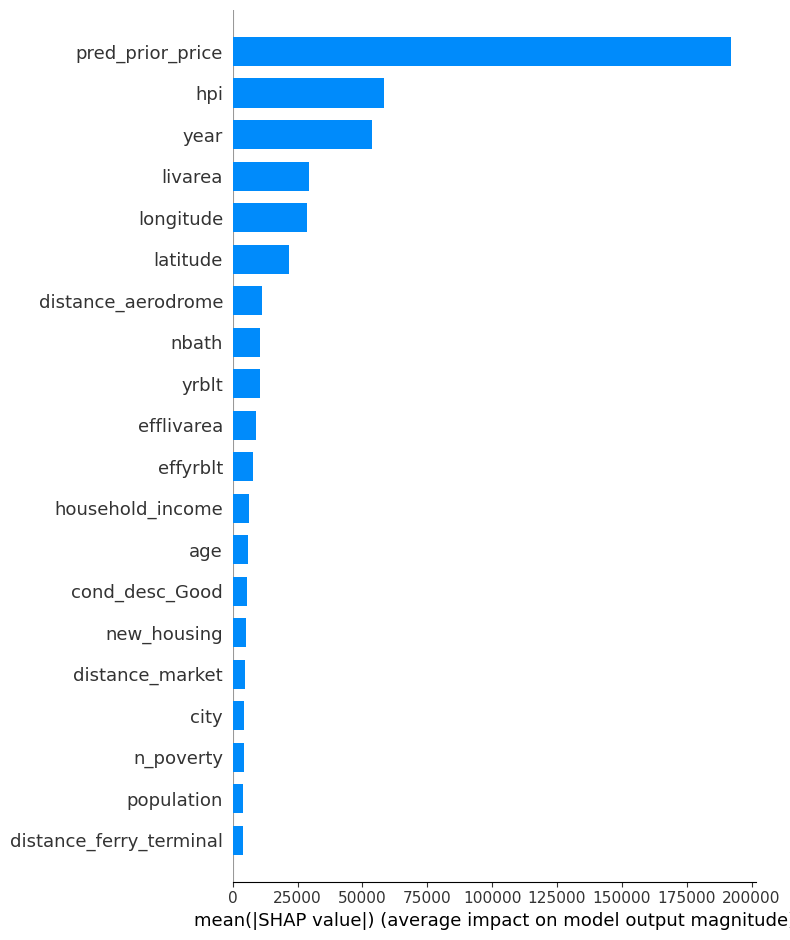

In [44]:
shap.summary_plot(shap_values, X_val_appr_2, plot_type="bar")

In [51]:
perm_importance_df.Feature.replace({0:"clust_00", 1:"clust_01",2: "clust_02", 3:"clust_03", 4:"clust_04", 5:"clust_05"})

59            pred_prior_price
32                         hpi
31                        year
6                      livarea
43                    latitude
42                   longitude
0                         city
8           distance_aerodrome
1                        yrblt
11             distance_market
40                         age
9      distance_ferry_terminal
7                   efflivarea
24                 n_transport
4                        nbath
2                     effyrblt
55                    clust_02
39                  n_employed
52                       pca_2
33            household_income
13              distance_hotel
56                    clust_03
34                 new_housing
10    distance_railway_station
50                       pca_0
58                    clust_05
23                 n_financial
15                 n_reli_inst
19                n_animalcare
36                   n_poverty
16                   n_edu_fac
35                  population
12      

TypeError: 'value' must be an instance of str or bytes, not a int

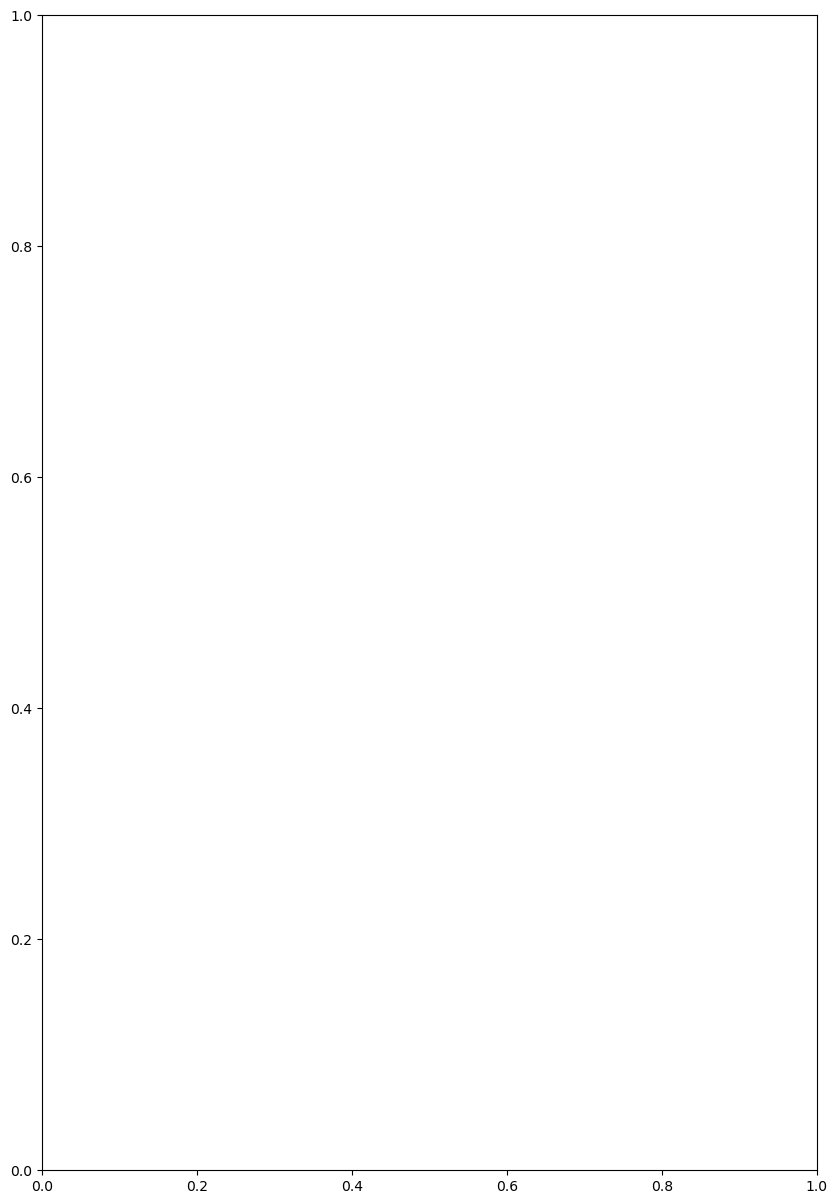

In [45]:
# Permutation importance
result = permutation_importance(model, X_val_appr_2, y_val, n_repeats=10, random_state=42, n_jobs=-1)
perm_importance_df = pd.DataFrame({'Feature': X_val_appr_2.columns, 'Importance': result.importances_mean})
perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False)

In [52]:
perm_importance_df["Feature"] = perm_importance_df.Feature.replace({0:"clust_00", 1:"clust_01",2: "clust_02", 3:"clust_03", 4:"clust_04", 5:"clust_05"})

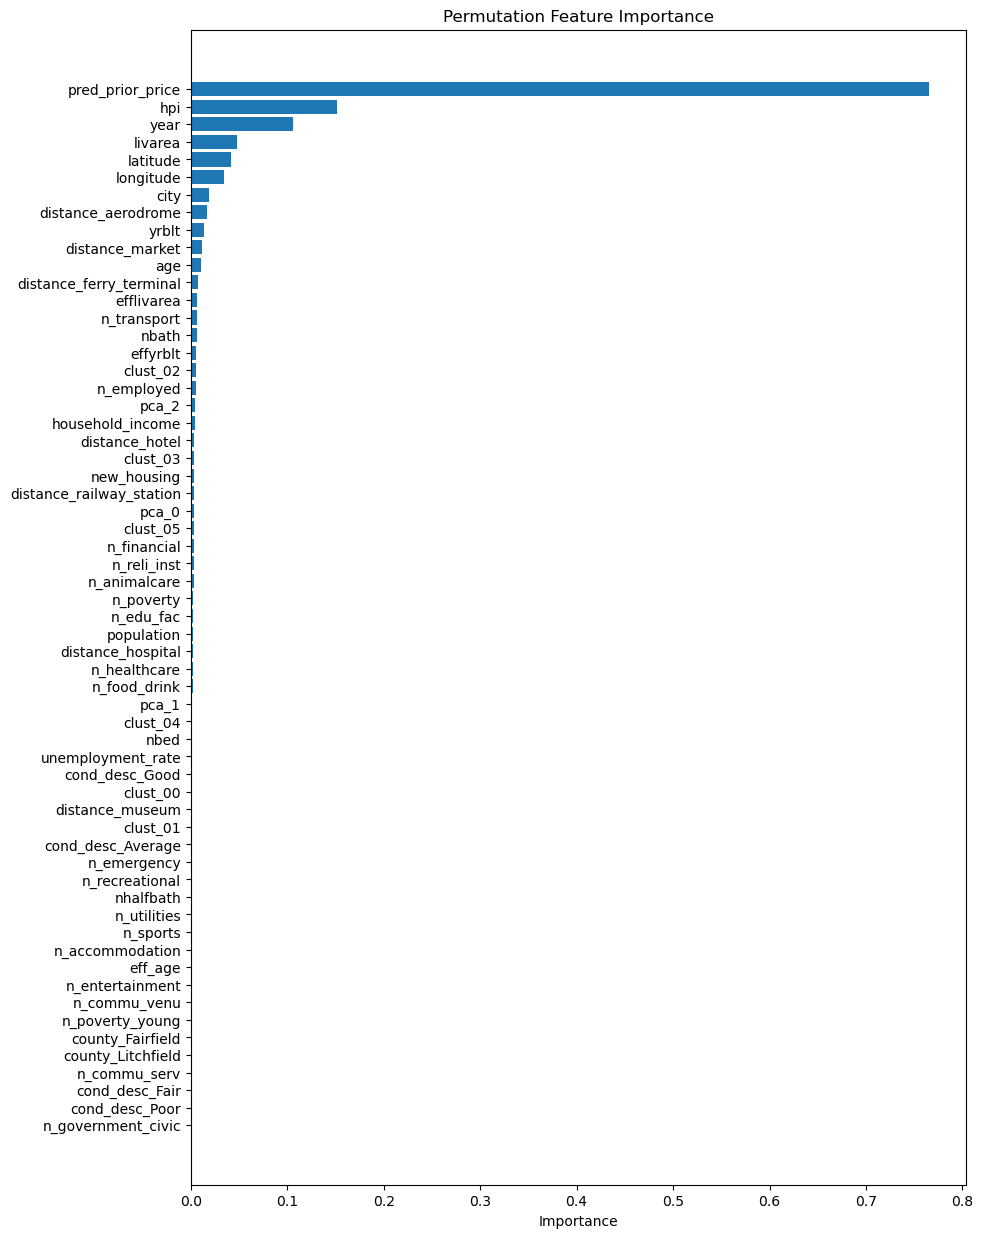

In [53]:
# Plot permutation importance
plt.figure(figsize=(10, 15))
plt.barh(perm_importance_df['Feature'], perm_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Permutation Feature Importance')
plt.gca().invert_yaxis()
plt.show()

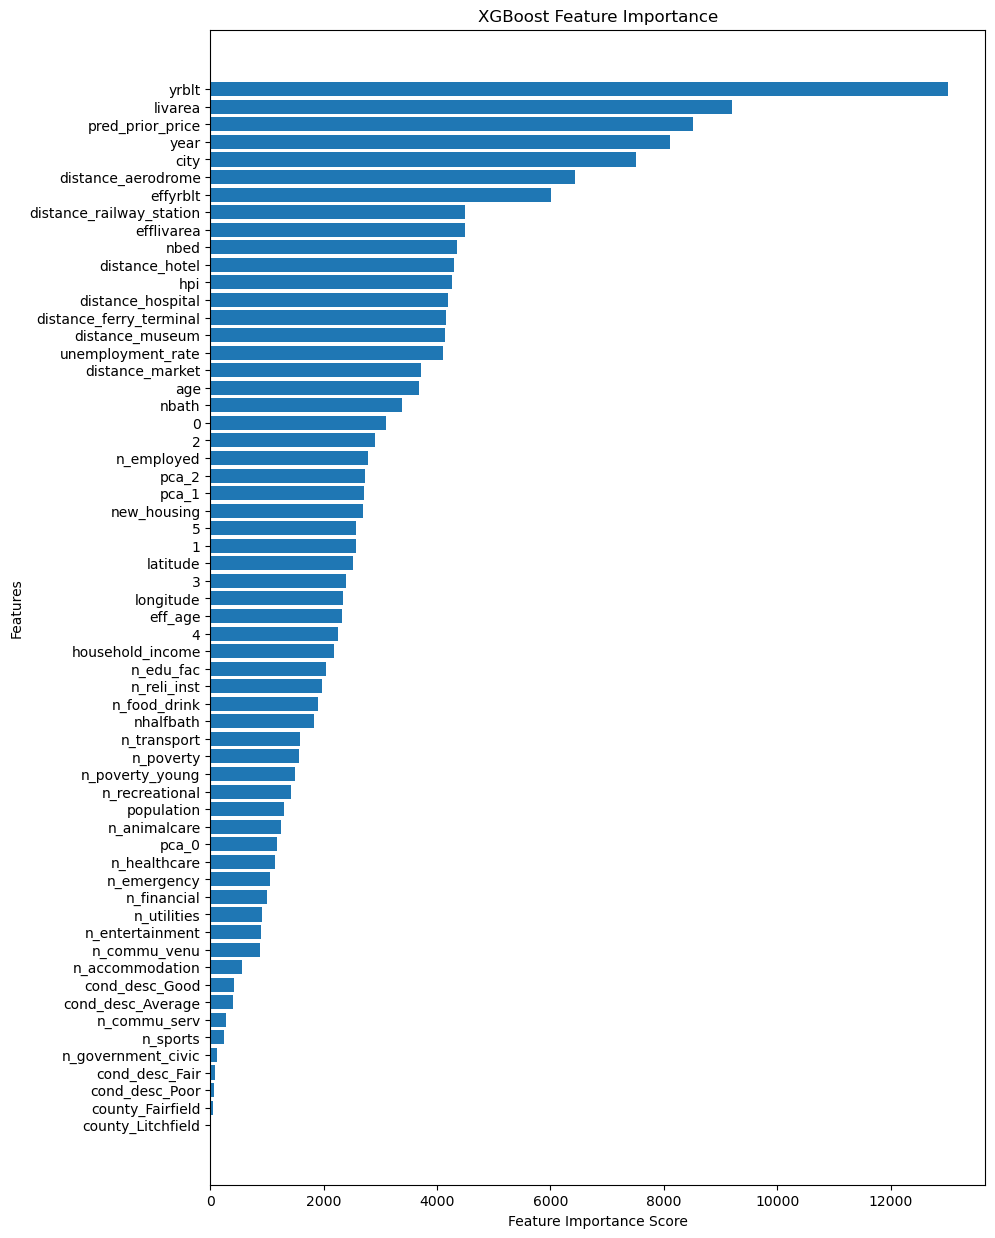

In [54]:
booster = model.get_booster()
# Get the feature importance
importance = booster.get_score(importance_type='weight')

# 6. Plot feature importance
# Convert the feature importance dictionary to a list
importance = sorted(importance.items(), key=lambda x: x[1], reverse=False)
features, scores = zip(*importance)

plt.figure(figsize=(10, 15))
plt.barh(features, scores)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance')
plt.show()

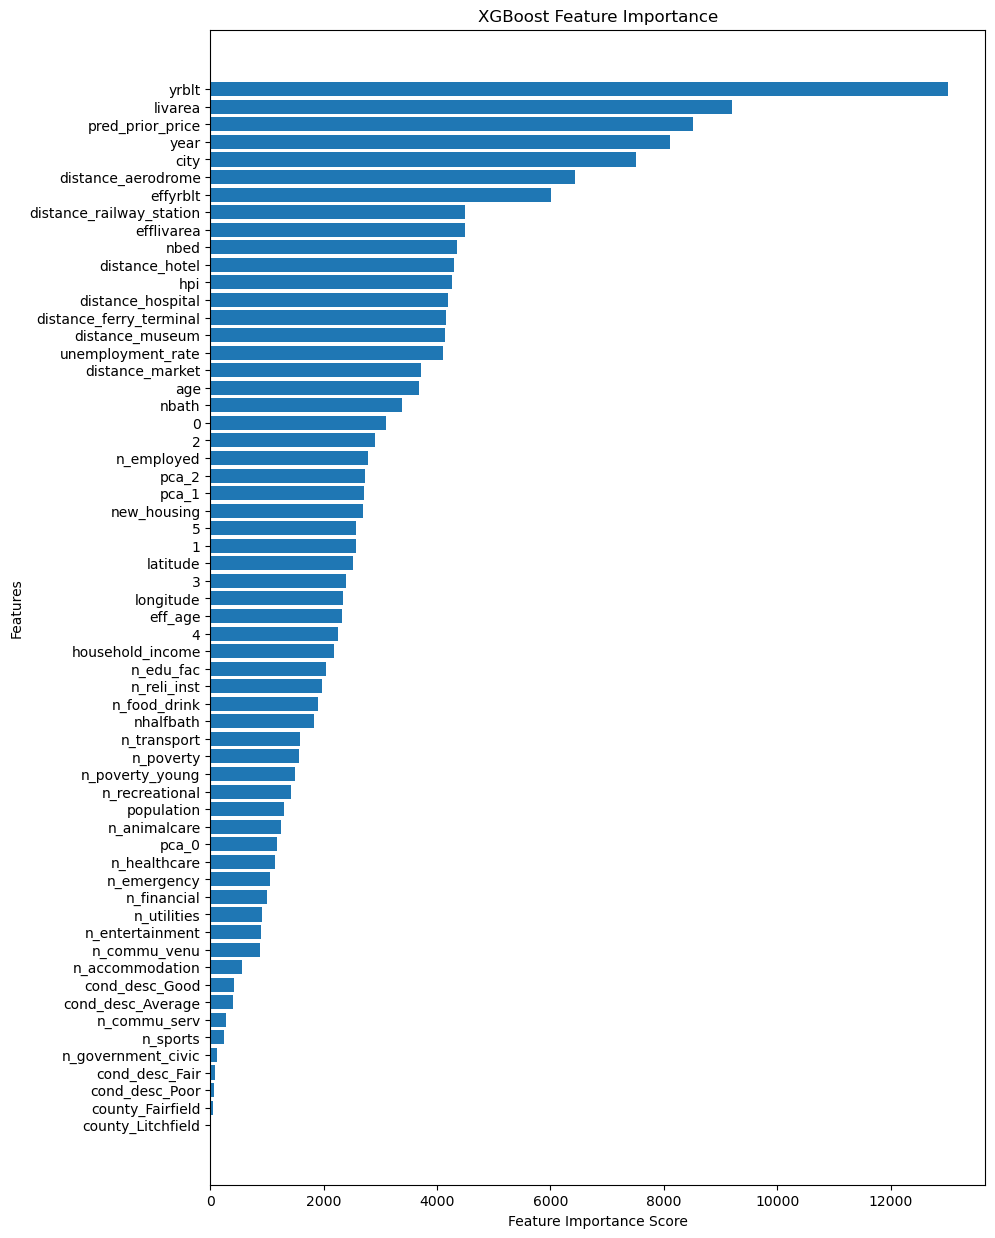

In [55]:
booster = model.get_booster()
# Get the feature importance
importance = booster.get_score(importance_type='weight')

# 6. Plot feature importance
# Convert the feature importance dictionary to a list
importance = sorted(importance.items(), key=lambda x: x[1], reverse=False)
features, scores = zip(*importance)

plt.figure(figsize=(10, 15))
plt.barh(features, scores)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance')
plt.show()

In [65]:
features = list(features)

In [68]:
features[28] = "clust_04"
features[31] = "clust_03"
features[33] = "clust_01"
features[34] = "clust_05"
features[39] = "clust_02"
features[40] = "clust_00"

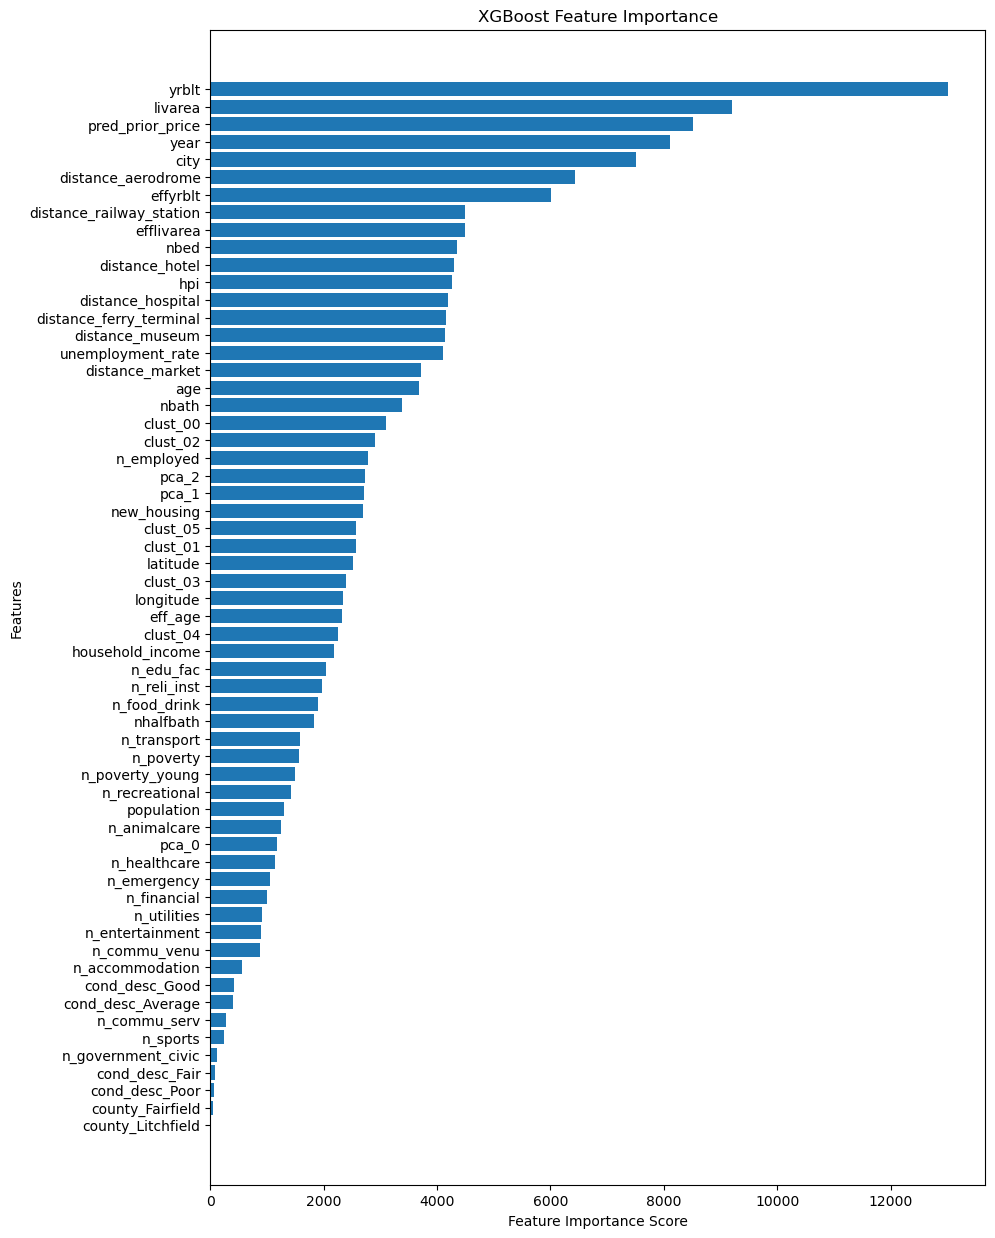

In [69]:
plt.figure(figsize=(10, 15))
plt.barh(features, scores)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance')
plt.show()